In [40]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [41]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [42]:
measurements_used = 1000
time_series_used = 3
energy_per_time = 1000
generate_graphs = False

get_timeseries = True
get_measurements = False

In [43]:
# exp_name = "compiler"
exp_name = "measuring_instrument"

In [44]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    linux
]

used_test_case_names = [
    # 'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [45]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_mi_names = [
        # ipg, scaphandre, lhm #, lhm, scaphandre, # plug, rapl
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        lhm#, plug
        # clamp, ipg, plug
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]


used_mi_names.sort()
used_compilers.sort()

### DUTs

In [46]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [47]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev
4,5,workstationtwo,win32nt,prod
5,6,mhk,win32nt,dev
6,7,workstationtwo,win32nt,dev


In [48]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod


### Test Cases

In [49]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [50]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [51]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [52]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,4,rapl,100
2,5,clamp,500
3,7,plug,100
4,8,plug,200
5,9,lhm,100
6,11,clamp,100
7,12,scaphandre,100


In [53]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

if rapl in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{rapl}' and {SAMPLE_RATE} == {rapl_sample_rate})")


if plug in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{plug}' and {SAMPLE_RATE} == {plug_sample_rate})")

if clamp in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{clamp}' and {SAMPLE_RATE} == {clamp_sample_rate})")
    
if scaphandre in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{scaphandre}' and {SAMPLE_RATE} == {scaphandre_sample_rate})")

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [54]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [55]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"
4,5,0,100,0,"[0, 1]"


In [56]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [57]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test
2,1,same-one-api-compiler-different-measuring-inst...
3,1,same-one-api-compiler-different-measuring-inst...
4,2,same-one-api-compiler-different-measuring-inst...
5,0,testing-phase


## Used Things

In [58]:
used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod


In [59]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [60]:
used_mi

,Id,Name,SampleRate
5,9,lhm,100


In [61]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [62]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [63]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

begin - mandelbrot.exe.lhm.workstationtwo.all.intel-one-api.win32nt.100.22
done


In [64]:
# [x for x in time_series[0]["fannkuch-redux.exe.rapl.workstationone.all.intel-one-api.unix"].iterrows()]

In [65]:
def get_rapl_column(df, column):
    last_rapl_value = 0
    rapl_values = []

    for _, rapl_row in df.iterrows():
        loaded_value = json.loads(rapl_row["AdditionalMetadata"])[column]
        rapl_value = loaded_value - last_rapl_value
        last_rapl_value = loaded_value
        rapl_values.append(rapl_value)

    return rapl_values


mandelbrot.exe.lhm.workstationtwo.all.intel-one-api.win32nt


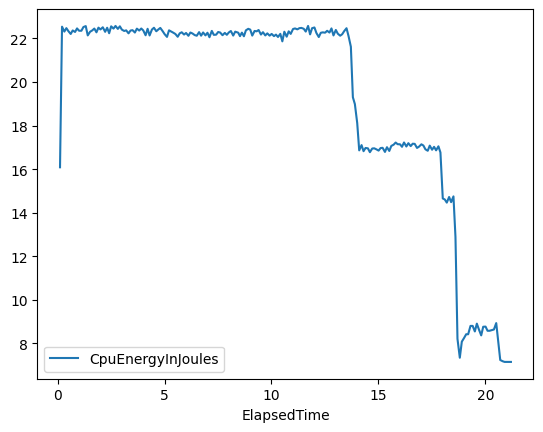

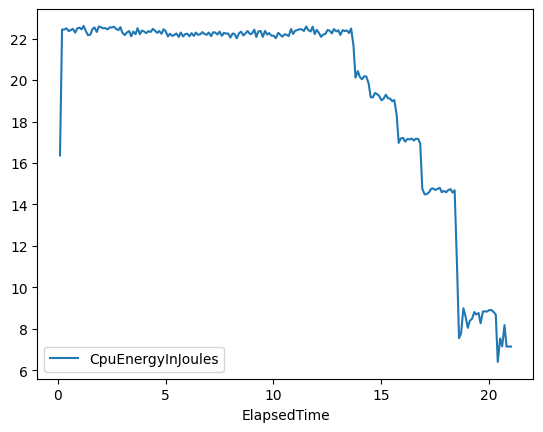

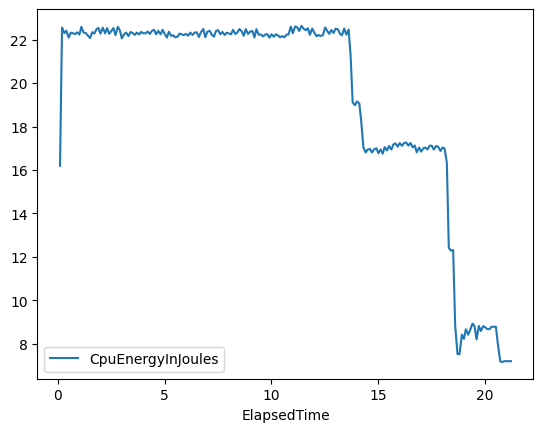

In [69]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            table.plot(x="ElapsedTime", y="ProcessorPowerInWatt")
        if "rapl" in key:
            table['rapl_column'] = get_rapl_column(table, "total_core")
            table.plot(x="ElapsedTime", y="rapl_column")
        plot.show()

In [ ]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
    )

In [ ]:
if get_measurements:
    for key, value in dram_energy_results.items():
        dram_energy_results[key] = value[:measurements_used]
        
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:measurements_used]

    for key, value in gpu_energy_results.items():
        gpu_energy_results[key] = value[:measurements_used]

    for key, value in duration_results.items():
        duration_results[key] = value[:measurements_used]
        
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:measurements_used]

    for key, value in gpu_dynamic_energy_consumption.items():
        gpu_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in dram_dynamic_energy_consumption.items():
        dram_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in idle_cpu_consumption_results.items():
        idle_cpu_consumption_results[key] = value[:measurements_used]
        
    for key, value in temperature_end.items():
        temperature_end[key] = value[:measurements_used]

    for key, value in temperature_begin.items():
        temperature_begin[key] = value[:measurements_used]

In [ ]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [ ]:
if get_measurements:
    ## Energy consumption for the entire test case

    dram_energy_results = convert_to_series(dram_energy_results)
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_energy_results = convert_to_series(cpu_energy_results)
    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_energy_results = convert_to_series(gpu_energy_results)
    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_results = convert_to_series(duration_results)
    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_energy_consumption = convert_to_series(dram_dynamic_energy_consumption)
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_energy_consumption = convert_to_series(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

    gpu_dynamic_energy_consumption = convert_to_series(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_consumption_results = convert_to_series(idle_cpu_consumption_results)
    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin = convert_to_series(temperature_begin)
    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end = convert_to_series(temperature_end)
    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))




In [ ]:
# cpu_clamp_total_list = cpu_df["fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt"]
# cpu_plug_total_list = cpu_df["fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt"]

# plug_idle_list = list(idle_cpu_df["fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt"])
# clamp_idle_list = list(idle_cpu_df["fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt"])

# cpu_clamp_total = sum(list(cpu_clamp_total_list)) / len(list(cpu_clamp_total_list))
# cpu_plug_total = sum(list(cpu_plug_total_list)) / len(list(cpu_plug_total_list))
# cpu_plug_dynamic = sum(list(plug_idle_list)) / len(list(plug_idle_list))
# cpu_clamp_dynamic = sum(list(clamp_idle_list)) / len(list(clamp_idle_list))

# print(f"idle:")
# print(f"clamp: {cpu_clamp_dynamic}, plug: {cpu_plug_dynamic}")
# print(f"total:")
# print(f"clamp: {cpu_clamp_total}, plug: {cpu_plug_total}")

In [ ]:
if get_measurements:
    for column in duration_df.columns:
        duration_df[column] = duration_df[column] / 1000

In [ ]:
if get_measurements:
    test_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=[dram_df.columns[0]])
    test_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()
    
    
    print("Combined DRAM Energy Consumption in Joules")
    dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=85)
    # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=['fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt'])
    dram_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()

    print("Combined CPU Energy Consumption in Joules")
    cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=85)
    cpu_boxplot.plot()
    cpu_boxplot
    plot.ylim(0,2500)
    plot.show()

    print("Combined GPU Energy Consumption in Joules")
    gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=85)
    gpu_boxplot.plot()
    plot.ylim(0,50)
    plot.show()

    print("Duration of Test Case")
    duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=85)
    duration_boxplot.plot()
    # plot.ylim(0,40)
    plot.show()

In [ ]:
if get_measurements:
    # print("Dynamic DRAM Energy Consumption in Watts")
    # dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_dram_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()

    print("Dynamic CPU Energy Consumption in Watts")
    dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=85)
    dynamic_cpu_boxplot.plot()
    plot.ylim(0,50)
    plot.show()

    # print("Dynamic GPU Energy Consumption in Watts")
    # dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_gpu_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()


In [ ]:
def list_to_label(lst, mapper):
    if len(lst) == 1:
        return mapper[lst[0]]
    elif len(lst) == 2:
        return f"{mapper[lst[0]]} and {mapper[lst[1]]}"
    else:
        return ", ".join([mapper[x] for x in lst[:-1]]) + f" and {mapper[lst[-1]]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [ ]:
box_plot_raw_data = [
    {
        "data" : cpu_dynamic_df,
        "name" : "CPU",
        "data_type" : "dynamic energy consumption",
        "width" : 0.4,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : cpu_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Total Energy Consumption (Joules)"
    },
    {
        "data" : dram_dynamic_df,
        "name" : "DRAM",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : dram_df,
        "name" : "DRAM",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Total Energy Consumption (Joules)"
    },
    {
        "data" : gpu_dynamic_df,
        "name" : "GPU",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : gpu_df,
        "name" : "GPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Total Energy Consumption (Watt)"
    },
    {
        "data" : duration_df,
        "name" : "Runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

NameError: name 'cpu_dynamic_df' is not defined

In [ ]:
dut_name_mapper = {
    "workstationone" : "DUT 1",
    "workstationtwo" : "DUT 2"
}

compiler_mapper = {
    "clang" : "Clang",
    "min-gw" : "MinGW",
    "intel-one-api" : "oneAPI",
    "msvc" : "MSVC"
}

test_case_mapper = {
    "fannkuch-redux.exe" : "FR",
    "mandelbrot.exe" : "MB",
    "n-body.exe" : "NB",
    "spectra-norm.exe" : "SN"
}

mi_mapper = {
    "ipg" : "IPG",
    "lhm" : "LHM",
    "clamp" : "Clamp",
    "plug" : "Plug",
    "scaphandre" : "SCAP"
}

os_mapper = {
    "linux" : 'LIN',
    "windows" : "WIN"
}

if generate_graphs and get_measurements:
    for plot_data in box_plot_raw_data:
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        
        title = f"The {data_type} of the {name}"
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(
            data, 
            used_test_case_names, 
            used_mi_names, 
            used_dut_name, 
            used_allocated_cores, 
            used_compiler_str, 
            used_os_names,
            dut_name_mapper,
            compiler_mapper,
            test_case_mapper,
            mi_mapper,
            os_mapper
            )
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}".lower()
        
        c_test_cases = list_to_label(used_test_case_names, test_case_mapper)
        c_compiler = list_to_label(used_compilers, compiler_mapper)
        c_duts = list_to_label(used_dut_name, dut_name_mapper)
        c_measuring_instrument = list_to_label(used_mi_names, mi_mapper)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [ ]:
# \addplot[mark=none, blue] coordinates {(1000,0) (1000,5)};

In [ ]:
cochrans_data = {
    "" : ["with", "without"]
}

if get_measurements:
    Z = 1.96
    E = 0.03

    # Z = 2.58
    # E = 0.01

    include_outliers = False

    used_df = cpu_dynamic_df

    for column in used_df.columns:
        used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
        
        values = used_df_without_outlisers
        n_zero_without = math_util.get_cochran(values, Z, E)
        
        values = list(used_df[column])
        n_zero = math_util.get_cochran(values, Z, E)
        
        cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1)]

pd.DataFrame(cochrans_data).T

,0,1
,with,without
